# Movielens 영화 데이터 기반 Session-Based Recommendation

# step1) 데이터 불러오기 및 확인

## 1-1. 필요 패키지 임포트

In [2]:
from pathlib import Path
import os

import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## 1-2. 데이터 불러오기

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/enode12/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

In [4]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


# step2) 데이터 분석

간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


## 2-1. `Time` 변수 `datetime` 형으로 변환
- `Time` 변수가 `int64` 타입이다.
- 데이터 파악 및 날짜 계산을 쉽게 하기 위해 `datatime` 형식으로 바꿔주자
    1. `Time` 변수를 문자열 형식으로 변환
    2. 문자열 형식을 다시 `datetime`형식으로 변환

In [6]:
data['UTC'] = data['Time'].astype('str')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   UserId  1000209 non-null  int32 
 1   ItemId  1000209 non-null  int32 
 2   Rating  1000209 non-null  int32 
 3   Time    1000209 non-null  int64 
 4   UTC     1000209 non-null  object
dtypes: int32(3), int64(1), object(1)
memory usage: 34.3+ MB


In [7]:
# unit='s'는 초단위까지 보여줌
data['UTC'] = pd.to_datetime(data['UTC'], unit='s')

- 변환 후 데이터

In [8]:
data.head()
data.tail()

,UserId,ItemId,Rating,Time,UTC
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43


,UserId,ItemId,Rating,Time,UTC
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26
1000042,6040,1221,4,998315055,2001-08-20 13:44:15


## 2-2. 데이터 확인
- 각 변수의 범위와 구성을 확인해보자

In [9]:
# 마크 다운 정리를 위한 코드
for col in data.columns:
    mini = data[col].min()
    maxi = data[col].max()
    print(f'|{col}|{mini}~{maxi}|',data[col].nunique(),'|')

|UserId|1~6040| 6040 |
|ItemId|1~3952| 3706 |
|Rating|1~5| 5 |
|Time|956703932~1046454590| 458455 |
|UTC|2000-04-25 23:05:32~2003-02-28 17:49:50| 458455 |


### 데이터 구성
|컬럼명|설명|데이터 범위|유니크값 개수|
|------|----------|--------|----|
|UserId|사용자 ID|1~6040| 6040 |
|ItemId|영화 ID|1~3952| 3706 |
|Rating|별점|1~5| 5 |
|Time|별점 부여 시간 (int64)|956703932~1046454590| 458455 |
|UTC|별점 부여 시간 (UTC)|2000-04-25 23:05:32~2003-02-28 17:49:50| 458455 |

- MovieLens 데이터에는 `SessionID` 대신 `UserID` 항목이 있다.
    - 같은 UserID더라도 별점을 남긴 시간에 따라 다른 세션으로 구분하는 것이 시계열적인 변화를 확인하는데 좋을 것이다.
- Rating 정보가 포함된다.
    - 직전에 봤던 영화를 선호하지 않는 경우 비슷한 영화를 추천해도 좋지 않을 것이다.
    - Rating이 낮은 데이터를 제거해보자.
- Time 변수는 1970년 1월 1일부터 경과된 초단위 시간을 정수로 저장한다.
    - datetime형으로 변환한 `UTC` 컬럼을 추가하자.

### 평점 분포 확인

<AxesSubplot:xlabel='Rating', ylabel='Density'>

<function matplotlib.pyplot.show(close=None, block=None)>

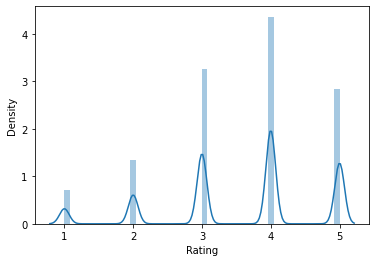

In [150]:
sns.distplot(data['Rating'])
plt.show

- 과반수 이상의 데이터가 3~5점이다 3점 이하의 별점 데이터는 버려도 될 듯 하다.

## 2-3. 시간 분석
- `SessionId` 대신 `UserId`와 별점을 남긴 시간 정보가 있다.
- 어떤 간격을 하나의 세션으로 볼 것인가?

- 시간 연산을 쉽게 하기 위해서 `UTC`를 index로 pivot한다.
- `UTC`를 기준으로 정렬해 한 사용자가 연달아서 별점을 남긴 시간대를 확인해보자.

- 어떤 사용자의 경우 1시간 내내 평가를 진행하고 있는 것을 볼 수 있다.

In [10]:
pivot = data.drop('Time', axis=1)
pivot = pivot.set_index('UTC').sort_index()
pivot.head(60)

,UserId,ItemId,Rating
UTC,,,
2000-04-25 23:05:32,6040,858,4
2000-04-25 23:05:54,6040,593,5
2000-04-25 23:05:54,6040,2384,4
2000-04-25 23:06:17,6040,1961,4
2000-04-25 23:06:17,6040,2019,5
2000-04-25 23:07:36,6040,573,4
2000-04-25 23:07:36,6040,1419,3
2000-04-25 23:07:36,6040,213,5
2000-04-25 23:07:36,6040,3111,5


- 30분 단위로 리샘플링 해본 경우 시간대별 사용자 명수와 평가 개수
- 시간대에 값이 없는 경우도 꽤 존재한다.

In [157]:
pivot.resample('30min').nunique()

,UserId,ItemId,Rating
UTC,,,
2000-04-25 23:00:00,2,85,4
2000-04-25 23:30:00,2,100,4
2000-04-26 00:00:00,2,14,5
2000-04-26 00:30:00,2,231,5
2000-04-26 01:00:00,3,332,5
...,...,...,...
2003-02-28 15:30:00,0,0,0
2003-02-28 16:00:00,0,0,0
2003-02-28 16:30:00,0,0,0


- 1시간 단위로 리샘플링해 사용자수와 평가개수 확인

In [158]:
pivot.resample('1h').nunique()

,UserId,ItemId,Rating
UTC,,,
2000-04-25 23:00:00,3,181,4
2000-04-26 00:00:00,3,241,5
2000-04-26 01:00:00,4,541,5
2000-04-26 02:00:00,6,354,5
2000-04-26 03:00:00,5,249,5
...,...,...,...
2003-02-28 13:00:00,1,2,2
2003-02-28 14:00:00,0,0,0
2003-02-28 15:00:00,1,1,1


- 2시간 단위로 리샘플링한 결과이다.

In [231]:
pivot.resample('2h').nunique()

,UserId,ItemId,Rating
UTC,,,
2000-04-25 22:00:00,3,181,4
2000-04-26 00:00:00,6,717,5
2000-04-26 02:00:00,8,528,5
2000-04-26 04:00:00,5,172,5
2000-04-26 06:00:00,1,204,5
...,...,...,...
2003-02-28 08:00:00,0,0,0
2003-02-28 10:00:00,0,0,0
2003-02-28 12:00:00,1,2,2


- 시간 단위를 늘렸음에도 `UserId`의 유니크한 값 개수가 폭증하지 않는 것으로 보아 동일한 사용자가 오랜 시간 평점을 남기는 경우도 존재함을 유추할 수 있다.

In [235]:
pivot.resample('30min').nunique().max()

UserId      87
ItemId    1600
Rating       5
dtype: int64

In [234]:
pivot.resample('1h').nunique().max()

UserId     111
ItemId    1896
Rating       5
dtype: int64

In [233]:
pivot.resample('2h').nunique().max()

UserId     158
ItemId    2402
Rating       5
dtype: int64

## 2-3-1. 시간차 파생 변수 추가
- 이전 행의 시간과 얼마의 차이가 나는지에 대한 파생 변수를 생성하자.

In [13]:
data['diff'] = (data.UTC - data.UTC.shift()).fillna(pd.Timedelta(seconds=0))
data

,UserId,ItemId,Rating,Time,UTC,diff
31,1,3186,4,978300019,2000-12-31 22:00:19,0 days 00:00:00
22,1,1270,5,978300055,2000-12-31 22:00:55,0 days 00:00:36
27,1,1721,4,978300055,2000-12-31 22:00:55,0 days 00:00:00
37,1,1022,5,978300055,2000-12-31 22:00:55,0 days 00:00:00
24,1,2340,3,978300103,2000-12-31 22:01:43,0 days 00:00:48
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,0 days 00:00:31
999988,6040,1921,4,997454464,2001-08-10 14:41:04,0 days 00:00:35
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,0 days 00:00:00
1000167,6040,161,3,997454486,2001-08-10 14:41:26,0 days 00:00:22


## 2-3-2. 동일 사용자 여부 파생변수 추가
- 이전 칼럼과의 시간차가 작더라도 사용자가 달라지면 다른 세션으로 구분해야한다.
- 사용자 변경 여부를 확인할 수 있는 파생변수를 추가하자.

In [62]:
data['SameUser'] = (data.UserId - data.UserId.shift()).fillna(0)
data

,UserId,ItemId,Rating,Time,UTC,diff,SameUser
31,1,3186,4,978300019,2000-12-31 22:00:19,0 days 00:00:00,0.0
22,1,1270,5,978300055,2000-12-31 22:00:55,0 days 00:00:36,0.0
27,1,1721,4,978300055,2000-12-31 22:00:55,0 days 00:00:00,0.0
37,1,1022,5,978300055,2000-12-31 22:00:55,0 days 00:00:00,0.0
24,1,2340,3,978300103,2000-12-31 22:01:43,0 days 00:00:48,0.0
...,...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,0 days 00:00:31,0.0
999988,6040,1921,4,997454464,2001-08-10 14:41:04,0 days 00:00:35,0.0
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,0 days 00:00:00,0.0
1000167,6040,161,3,997454486,2001-08-10 14:41:26,0 days 00:00:22,0.0


- 사용자가 바뀐 행 출력

실제 시간차는 얼마 나지 않지만 다른 사용자의 경우를 구분하고 있다.

In [64]:
data[data['SameUser'] ==1.0]

,UserId,ItemId,Rating,Time,UTC,diff,SameUser
130,2,1198,4,978298124,2000-12-31 21:28:44,-7 days +21:49:33,1.0
217,3,593,3,978297018,2000-12-31 21:10:18,-1 days +23:07:24,1.0
234,4,1210,3,978293924,2000-12-31 20:18:44,-1 days +22:43:40,1.0
325,5,2717,1,978241072,2000-12-31 05:37:52,-1 days +09:13:10,1.0
461,6,3072,4,978236075,2000-12-31 04:14:35,-1 days +21:04:50,1.0
...,...,...,...,...,...,...,...
999375,6036,1721,4,956709349,2000-04-26 00:35:49,-1 days +22:48:29,1.0
999568,6037,1882,1,956708997,2000-04-26 00:29:57,-1 days +11:10:01,1.0
999726,6038,920,3,956706827,2000-04-25 23:53:47,-2 days +21:36:27,1.0
999794,6039,282,4,956705158,2000-04-25 23:25:58,-1 days +20:39:14,1.0


## 2-3-3. SessionId 부여
- 2시간 이내에 동일한 사용자가 평잠을 부여한 경우를 하나의 세션으로 취급한다.

In [65]:
session_idx = 1
def split_session(data):
    global session_idx
    if data['diff'] > timedelta(hours=2) or data['SameUser']==1.0:
        session_idx += 1
    return session_idx

In [66]:
data['SessionId'] = data.apply(split_session, axis=1)

In [67]:
data

,UserId,ItemId,Rating,Time,UTC,diff,SameUser,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,0 days 00:00:00,0.0,1
22,1,1270,5,978300055,2000-12-31 22:00:55,0 days 00:00:36,0.0,1
27,1,1721,4,978300055,2000-12-31 22:00:55,0 days 00:00:00,0.0,1
37,1,1022,5,978300055,2000-12-31 22:00:55,0 days 00:00:00,0.0,1
24,1,2340,3,978300103,2000-12-31 22:01:43,0 days 00:00:48,0.0,1
...,...,...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,0 days 00:00:31,0.0,23824
999988,6040,1921,4,997454464,2001-08-10 14:41:04,0 days 00:00:35,0.0,23824
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,0 days 00:00:00,0.0,23824
1000167,6040,161,3,997454486,2001-08-10 14:41:26,0 days 00:00:22,0.0,23824


### 세션 분리 결과 확인

In [261]:
# 하나의 사용자더라도 여러개의 세션 아이디로 나뉜 것을 볼 수 있다.
sess = data.set_index(['UserId','SessionId'])

- 나뉜 세션 아이디도 비교적 정확하다.

In [251]:
sess.loc[(1,1)]

ItemId  Rating       Time                 UTC  \
UserId SessionId                                                  
1      1            3186       4  978300019 2000-12-31 22:00:19   
       1            1270       5  978300055 2000-12-31 22:00:55   
       1            1721       4  978300055 2000-12-31 22:00:55   
       1            1022       5  978300055 2000-12-31 22:00:55   
       1            2340       3  978300103 2000-12-31 22:01:43   
       1            1836       5  978300172 2000-12-31 22:02:52   
       1            3408       4  978300275 2000-12-31 22:04:35   
       1            2804       5  978300719 2000-12-31 22:11:59   
       1            1207       4  978300719 2000-12-31 22:11:59   
       1            1193       5  978300760 2000-12-31 22:12:40   
       1             720       3  978300760 2000-12-31 22:12:40   
       1             260       4  978300760 2000-12-31 22:12:40   
       1             919       4  978301368 2000-12-31 22:22:48   
       1             608       4  978301398 2000-12-31 22:23:18   
       1            2692       4  978301570 2000-12-31 22:26:10   
       1            1961       5  978301590 2000-12-31 22:26:30   
       1            2028       5  978301619 2000-12-31 22:26:59   
       1            3105       5  978301713 2000-12-31 22:28:33   
       1             938       4  978301752 2000-12-31 22:29:12   
       1            1035       5  978301753 2000-12-31 22:29:13   
       1            1962       4  978301753 2000-12-31 22:29:13   
       1            2018       4  978301777 2000-12-31 22:29:37   
       1             150       5  978301777 2000-12-31 22:29:37   
       1            1028       5  978301777 2000-12-31 22:29:37   
       1            1097       4  978301953 2000-12-31 22:32:33   
       1             914       3  978301968 2000-12-31 22:32:48   
       1            1287       5  978302039 2000-12-31 22:33:59   
       1            2797       4  978302039 2000-12-31 22:33:59   
       1            2762       4  978302091 2000-12-31 22:34:51   
       1            1246       4  978302091 2000-12-31 22:34:51   
       1             661       3  978302109 2000-12-31 22:35:09   
       1            2918       4  978302124 2000-12-31 22:35:24   
       1             531       4  978302149 2000-12-31 22:35:49   
       1            3114       4  978302174 2000-12-31 22:36:14   
       1            2791       4  978302188 2000-12-31 22:36:28   
       1            2321       3  978302205 2000-12-31 22:36:45   
       1            1029       5  978302205 2000-12-31 22:36:45   
       1            1197       3  978302268 2000-12-31 22:37:48   
       1             594       4  978302268 2000-12-31 22:37:48   
       1            2398       4  978302281 2000-12-31 22:38:01   

                            diff  SameUser  
UserId SessionId                            
1      1         0 days 00:00:00       0.0  
       1         0 days 00:00:36       0.0  
       1         0 days 00:00:00       0.0  
       1         0 days 00:00:00       0.0  
       1         0 days 00:00:48       0.0  
       1         0 days 00:01:09       0.0  
       1         0 days 00:01:43       0.0  
       1         0 days 00:07:24       0.0  
       1         0 days 00:00:00       0.0  
       1         0 days 00:00:41       0.0  
       1         0 days 00:00:00       0.0  
       1         0 days 00:00:00       0.0  
       1         0 days 00:10:08       0.0  
       1         0 days 00:00:30       0.0  
       1         0 days 00:02:52       0.0  
       1         0 days 00:00:20       0.0  
       1         0 days 00:00:29       0.0  
       1         0 days 00:01:34       0.0  
       1         0 days 00:00:39       0.0  
       1         0 days 00:00:01       0.0  
       1         0 days 00:00:00       0.0  
       1         0 days 00:00:24       0.0  
       1         0 days 00:00:00       0.0  
       1         0 days 00:00:00       0.0  
       1         0 days 00:02:56 

In [254]:
sess.loc[(1,2)]

ItemId  Rating       Time                 UTC  \
UserId SessionId                                                  
1      2            1545       4  978824139 2001-01-06 23:35:39   
       2             527       5  978824195 2001-01-06 23:36:35   
       2             595       5  978824268 2001-01-06 23:37:48   
       2            2687       3  978824268 2001-01-06 23:37:48   
       2             745       3  978824268 2001-01-06 23:37:48   
       2             588       4  978824268 2001-01-06 23:37:48   
       2               1       5  978824268 2001-01-06 23:37:48   
       2            2355       5  978824291 2001-01-06 23:38:11   
       2            2294       4  978824291 2001-01-06 23:38:11   
       2             783       4  978824291 2001-01-06 23:38:11   
       2            1566       4  978824330 2001-01-06 23:38:50   
       2            1907       4  978824330 2001-01-06 23:38:50   
       2              48       5  978824351 2001-01-06 23:39:11   

                            diff  SameUser  
UserId SessionId                            
1      2         6 days 00:57:38       0.0  
       2         0 days 00:00:56       0.0  
       2         0 days 00:01:13       0.0  
       2         0 days 00:00:00       0.0  
       2         0 days 00:00:00       0.0  
       2         0 days 00:00:00       0.0  
       2         0 days 00:00:00       0.0  
       2         0 days 00:00:23       0.0  
       2         0 days 00:00:00       0.0  
       2         0 days 00:00:00       0.0  
       2         0 days 00:00:39       0.0  
       2         0 days 00:00:00       0.0  
       2         0 days 00:00:21       0.0

## 2-4. 세션 길이 확인
- 사용자 ID같고 UTC 2시간 내로 같은 경우를 하나의 세션으로 보기로 했다.

In [68]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(23825, 3706)

In [69]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1         40
2         13
3        129
4         51
5         21
        ... 
23821      7
23822     14
23823      1
23824     21
23825      1
Length: 23825, dtype: int64

In [70]:
session_length.min(), session_length.max()

(1, 1442)

- 전체 세션 길이의 99분위수는 407이었다.

In [71]:
session_length.quantile(0.99)

407.0

- 세션길이 1442는 이상치인가?

In [72]:
long_session = session_length[session_length==1442].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,UTC,diff,SameUser,SessionId
137631,889,1266,3,975247862,2000-11-26 14:11:02,-1 days +17:39:54,1.0,3443
137864,889,2430,3,975247862,2000-11-26 14:11:02,0 days 00:00:00,0.0,3443
137889,889,1643,3,975247862,2000-11-26 14:11:02,0 days 00:00:00,0.0,3443
138039,889,3461,3,975247862,2000-11-26 14:11:02,0 days 00:00:00,0.0,3443
138316,889,1193,1,975247862,2000-11-26 14:11:02,0 days 00:00:00,0.0,3443
...,...,...,...,...,...,...,...,...
138442,889,1543,1,975261851,2000-11-26 18:04:11,0 days 00:00:00,0.0,3443
138211,889,617,3,975261864,2000-11-26 18:04:24,0 days 00:00:13,0.0,3443
138215,889,476,2,975261864,2000-11-26 18:04:24,0 days 00:00:00,0.0,3443
138394,889,844,3,975261879,2000-11-26 18:04:39,0 days 00:00:15,0.0,3443


In [262]:
data[data['SessionId']==long_session].describe()

,UserId,ItemId,Rating,Time,diff,SameUser,SessionId
count,1437.0,1437.000000,1437.000000,1.437000e+03,1437,1437.000000,1437.0
mean,889.0,1992.300626,2.839944,9.752527e+08,-1 days +23:59:53.869867781,0.000696,3443.0
std,0.0,1145.879807,1.019034,3.916356e+03,0 days 00:10:24.432256153,0.026380,0.0
min,889.0,1.000000,1.000000,9.752479e+08,-1 days +17:39:54,0.000000,3443.0
25%,889.0,1068.000000,2.000000,9.752498e+08,0 days 00:00:00,0.000000,3443.0
50%,889.0,1956.000000,3.000000,9.752515e+08,0 days 00:00:00,0.000000,3443.0
75%,889.0,3002.000000,3.000000,9.752546e+08,0 days 00:00:00,0.000000,3443.0
max,889.0,3952.000000,5.000000,9.752619e+08,0 days 01:38:37,1.000000,3443.0


In [263]:
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,UTC,diff,SameUser,SessionId
137631,889,1266,3,975247862,2000-11-26 14:11:02,-1 days +17:39:54,1.0,3443
137864,889,2430,3,975247862,2000-11-26 14:11:02,0 days 00:00:00,0.0,3443
137889,889,1643,3,975247862,2000-11-26 14:11:02,0 days 00:00:00,0.0,3443
138039,889,3461,3,975247862,2000-11-26 14:11:02,0 days 00:00:00,0.0,3443
138316,889,1193,1,975247862,2000-11-26 14:11:02,0 days 00:00:00,0.0,3443
...,...,...,...,...,...,...,...,...
138442,889,1543,1,975261851,2000-11-26 18:04:11,0 days 00:00:00,0.0,3443
138211,889,617,3,975261864,2000-11-26 18:04:24,0 days 00:00:13,0.0,3443
138215,889,476,2,975261864,2000-11-26 18:04:24,0 days 00:00:00,0.0,3443
138394,889,844,3,975261879,2000-11-26 18:04:39,0 days 00:00:15,0.0,3443


- 4시간 동안 평가를 했다는 점이 조금 거슬리긴 한다.

## 2-4. 세션 길이 시각화

In [78]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1      0.272529
2      0.373767
3      0.424218
4      0.456118
5      0.483064
         ...   
768    0.998825
769    0.998867
771    0.998909
775    0.998951
777    0.998993
Length: 547, dtype: float64

In [137]:
# 그래프 외의 정보 나와서 설정 변경
InteractiveShell.ast_node_interactivity = 'last_expr'

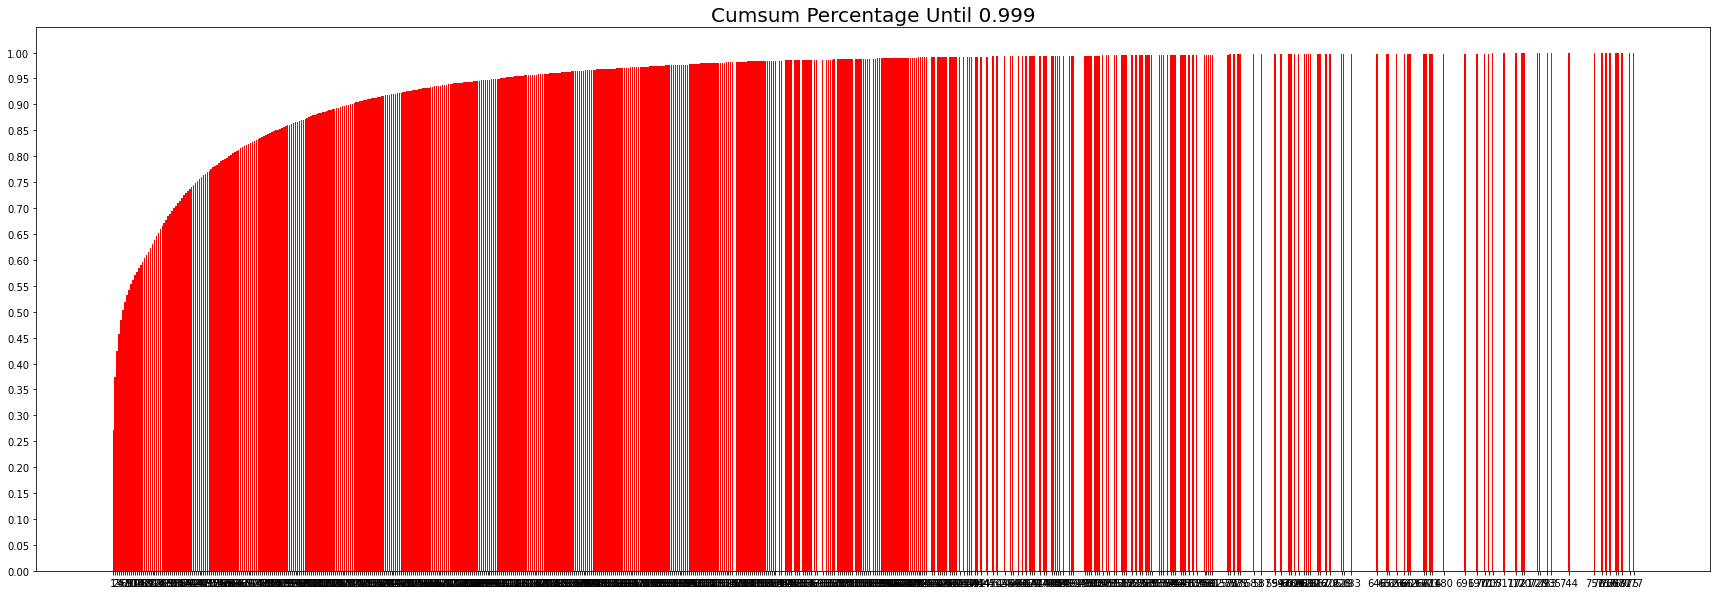

In [138]:
plt.figure(figsize=(30, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [139]:
# 다시 여러 셀 출력
InteractiveShell.ast_node_interactivity = 'all'

## 2-5. 세션 시간
- 해당 데이터는 2000-04-25 23:05:32 부터 2003-02-28 17:49:50 까지의 데이터이다.

In [81]:
oldest, latest = data['UTC'].min(), data['UTC'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


# step3) 데이터 전처리
- def `cleanse_short_session()`
- 우리는 한 세션 내의 활동을 기반으로 바로 사용자가 원하는 영화가 무엇일지를 알아내는 것이 목적이기 때문에 한 사용자가 남긴 평가가 일정 개수 이상인 정보만 보고자한다.
- def `cleanse_unpopular_item()`
- 사용자의 평가가 많지 않은 경우 추천해도 긍정적인 영향을 얻을 확률이 상대적으로 낮기 때문에 특정 평가 개수 이하의 항목에 대한 평가는 아예 제거한다.

In [82]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [83]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time,UTC,diff,SameUser,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,0 days 00:00:00,0.0,1
22,1,1270,5,978300055,2000-12-31 22:00:55,0 days 00:00:36,0.0,1
27,1,1721,4,978300055,2000-12-31 22:00:55,0 days 00:00:00,0.0,1
37,1,1022,5,978300055,2000-12-31 22:00:55,0 days 00:00:00,0.0,1
24,1,2340,3,978300103,2000-12-31 22:01:43,0 days 00:00:48,0.0,1
...,...,...,...,...,...,...,...,...
999923,6040,232,5,997454398,2001-08-10 14:39:58,0 days 00:00:31,0.0,23824
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,0 days 00:00:31,0.0,23824
999988,6040,1921,4,997454464,2001-08-10 14:41:04,0 days 00:00:35,0.0,23824
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,0 days 00:00:00,0.0,23824


# step4) 미니 배치 구성

- 학습을 위한 데이터셋과 미니 배치를 구성한다.
- 따로 긴 세션에 대한 전처리를 하지 않았으므로 Session-Parallel Mini Batch 작업이 성능 향상에 도움을 줄 것이다.

## 4-1. train, val, test 데이터셋 분리
- 별도로 `train`, `test` 데이터셋 구분이 없기 때문에 전처리한 데이터셋을 분리해주자.
- 데이터의 기간은 우선 전체로 한다.
- `validation`의 데이터의 기간은 최신 16~31일
- `test` 데이터 셋의 기간은 최신 15일
- `train`의 기간은 그 외 전부로 한다.

In [85]:
train_data = data.drop(['Time','diff','SameUser'],axis=1)
train_data

,UserId,ItemId,Rating,UTC,SessionId
31,1,3186,4,2000-12-31 22:00:19,1
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,1
37,1,1022,5,2000-12-31 22:00:55,1
24,1,2340,3,2000-12-31 22:01:43,1
...,...,...,...,...,...
999923,6040,232,5,2001-08-10 14:39:58,23824
1000019,6040,2917,4,2001-08-10 14:40:29,23824
999988,6040,1921,4,2001-08-10 14:41:04,23824
1000172,6040,1784,3,2001-08-10 14:41:04,23824


In [97]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['UTC'].max()
    session_last_time = data.groupby('SessionId')['UTC'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [101]:
tr, test = split_by_date(train_data, n_days=15)
tr, val = split_by_date(tr, n_days=15)

In [102]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["UTC"].min()}\n'
          f'\t Last Time : {data["UTC"].max()}\n')

In [103]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 991631
	 Sessions: 6040
	 Items: 3405
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2003-01-29 00:35:10

* valid Set Stats Info
	 Events: 846
	 Sessions: 37
	 Items: 667
	 First Time : 2003-01-29 02:58:33
	 Last Time : 2003-02-13 02:34:39

* test Set Stats Info
	 Events: 603
	 Sessions: 39
	 Items: 504
	 First Time : 2003-02-13 18:06:30
	 Last Time : 2003-02-28 17:49:50



## 3-2. train data 기준 인덱싱

In [110]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [111]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

In [112]:
tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [113]:
tr = pd.read_pickle(save_path / 'train.pkl')
val = pd.read_pickle(save_path / 'valid.pkl')
test = pd.read_pickle(save_path / 'test.pkl')
tr.head()
val.head()
test.head()

,UserId,ItemId,Rating,UTC,SessionId,item_idx
31,1,3186,4,2000-12-31 22:00:19,1,0
22,1,1270,5,2000-12-31 22:00:55,1,1
27,1,1721,4,2000-12-31 22:00:55,1,2
37,1,1022,5,2000-12-31 22:00:55,1,3
24,1,2340,3,2000-12-31 22:01:43,1,4


,UserId,ItemId,Rating,UTC,SessionId,item_idx
28443,195,468,3,2003-02-11 17:42:36,913,1309
28255,195,2748,1,2003-02-11 18:23:28,913,1695
28281,195,410,2,2003-02-11 18:23:28,913,1835
28389,195,2791,3,2003-02-11 18:23:28,913,34
28391,195,2792,2,2003-02-11 18:23:28,913,1194


,UserId,ItemId,Rating,UTC,SessionId,item_idx
27895,195,2247,2,2003-02-16 00:48:27,914,1402
27846,195,1356,2,2003-02-16 01:27:14,914,549
27901,195,1374,3,2003-02-16 01:27:14,914,740
27902,195,1375,2,2003-02-16 01:27:14,914,641
28241,195,329,2,2003-02-16 01:27:14,914,670


## 4-2. `SessionDataset` 클래스
- 데이터로 부터 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 저장
- `SessionDataset.click_offsets` : 각 세션이 시작된 인덱스 담는 멤버변수
- `SessionDataset.session_idx` : 각 세션을 인덱싱한 `np.array`

In [114]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

- 인스턴스 변수

In [115]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,UTC,SessionId,item_idx
31,1,3186,4,2000-12-31 22:00:19,1,0
22,1,1270,5,2000-12-31 22:00:55,1,1
27,1,1721,4,2000-12-31 22:00:55,1,2
37,1,1022,5,2000-12-31 22:00:55,1,3
24,1,2340,3,2000-12-31 22:01:43,1,4
36,1,1836,5,2000-12-31 22:02:52,1,5
3,1,3408,4,2000-12-31 22:04:35,1,6
7,1,2804,5,2000-12-31 22:11:59,1,7
47,1,1207,4,2000-12-31 22:11:59,1,8
0,1,1193,5,2000-12-31 22:12:40,1,9


In [116]:
tr_dataset.click_offsets

array([     0,     40,     53, ..., 991596, 991610, 991631], dtype=int32)

In [117]:
tr_dataset.session_idx

array([    0,     1,     2, ..., 17216, 17217, 17218])

## 4-3. `SessionDataLoader`
- `SessionDataset` 객체로 부터 `Session-Parallel mini-batch` 만드는 클래스
- `__iter__` 메소드는 모델 이눗, 라벨, 세션이 끝나는 곳의 위치를 `yield`

In [118]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [119]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,UTC,SessionId,item_idx
31,1,3186,4,2000-12-31 22:00:19,1,0
22,1,1270,5,2000-12-31 22:00:55,1,1
27,1,1721,4,2000-12-31 22:00:55,1,2
37,1,1022,5,2000-12-31 22:00:55,1,3
24,1,2340,3,2000-12-31 22:01:43,1,4
36,1,1836,5,2000-12-31 22:02:52,1,5
3,1,3408,4,2000-12-31 22:04:35,1,6
7,1,2804,5,2000-12-31 22:11:59,1,7
47,1,1207,4,2000-12-31 22:11:59,1,8
0,1,1193,5,2000-12-31 22:12:40,1,9


In [120]:
iter_ex = iter(tr_data_loader)

- 아래 셀을 반복 실행하면 `next`로 이터레이터 소환해서 계속 다음 데이터 생성
- input, output, mask의 값

In [121]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 40 53 65]
Label Item Idx are :       [ 1 41 54 62]
Previous Masked Input Idx are []


# step5) 모델 구성

## 5-1. 모델 평가 지표
- def `mrr_k(pred, truth, k)` : `MRR`을 구현한 함수
    - 0부터 k-1번째 예측 중에 정답이 나온 가장 빠른 인덱스의 역수 반환
    - 정답을 빨리 추천할 수록 좋은 것
- def `recall_k(red, truth, k)` : `recall@k`를 구현한 함수
    - 세션 기반 추천에서는 모델이 제시한 k개의 아이템 중에서 사용자가 클릭하거나 구매한 n개의 아이템이 많아야 좋다.
    - 전체 데이터 집단의 재현율이 아니라 추천한 k개의 아이템 중에서의 재현율을 측정

In [104]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## 5-2. 모델 구성

In [106]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [ ]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

In [108]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [130]:
args = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
model = create_model(args)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(16, 1, 3405)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      518550    
_________________________________________________________________
dropout_3 (Dropout)          (16, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (16, 3405)                173655    
Total params: 692,205
Trainable params: 692,205
Non-trainable params: 0
_________________________________________________________________


# step5) 모델 학습

다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [124]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # validation set 및 test set 평가 
                                            # mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값 기준 내림차순 정렬

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [131]:
train_model(model, args)

Train:   0%|          | 0/60900 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.12]

	 - Recall@20 epoch 1: 0.096591
	 - MRR@20    epoch 1: 0.023107



Train:   0%|          | 0/60900 [00:00<?, ?it/s, accuracy=0.125, train_loss=6.03] 

	 - Recall@20 epoch 2: 0.107955
	 - MRR@20    epoch 2: 0.040040



Evaluation:  22%|██▏       | 11/50 [00:01<00:04,  8.63it/s]

	 - Recall@20 epoch 3: 0.102273
	 - MRR@20    epoch 3: 0.038497



# step7) 모델 테스트

- 이전에 분리해둔 test set으로 Recall@k와 MRR@k를 계산한다.

In [219]:
def test_model(model1, arg, test1):
    test_recall, test_mrr = get_metrics(test1, model1, arg, 10)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [160]:
test_model(model, args, test)

Evaluation:  32%|███▏      | 11/34 [00:00<00:01, 12.06it/s]

	 - Recall@20: 0.119318
	 - MRR@20: 0.058640



# step8) 모델 실험

- 다양한 방법으로 데이터를 추가 전처리해 모델을 학습시켜보자.
- 하이퍼 파라미터도 조절해서 더 나은 성능의 모델을 만들어보자.

In [192]:
# 마크다운 정리를 위한 코드
def show_difference(test, model, args, model_name):
    test_recall, test_mrr = get_metrics(test, model, args, int(args.k))
    print(f'|모델명|batch size|hidden_size|drop_rate|epochs|metrics k|Recall@{args.k}|MRR@{args.k}|')
    print('|-------|------|----|----|----|----|----|----|')
    print(f'|{model_name}|{args.batch_size}|{args.hsz}|{args.drop_rate}|{args.epochs}|{args.k}|{test_recall:3f}|{test_mrr:3f}|')

- 실험 결과

결과적으로 별다른 추가 전처리를 하지 않은 기본 모델에 배치사이즈를 늘린 경우가 가장 좋은 재현율을 보였다.


|모델 특이사항|batch size|hidden_size|drop_rate|epochs|metrics k|Recall@k|MRR@k|
|--------|------|----|----|----|----|----|----|
|기본|16|50|0.1|3|20|0.119318|0.058640|
|평점 3.0 미만 제거|32|100|0.1|10|20|0.140625|0.058903|
|2002년 이후|32|50|0.1|10|20|0.048295|0.017407|
|2002년 이후 ver2|16|50|0.1|10|20|0.092262|0.030956|
|기본 배치 사이즈 증가|32|50|0.1|10|20|0.161932|0.061652|

## 8-1. 별점 3점 미만 제거
- 별점이 낮은 영화는 세션에 기반해 추천해도 좋은 평가를 받지 못할 것이다.
- 3점 미만의 경우는 제거하자.

- 제거 전 : 993080 rows × 5 columns

In [180]:
train_data = data.drop(['Time','diff','SameUser'],axis=1)
train_data = train_data[train_data['Rating']>=3]
train_data

,UserId,ItemId,Rating,UTC,SessionId
31,1,3186,4,2000-12-31 22:00:19,1
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,1
37,1,1022,5,2000-12-31 22:00:55,1
24,1,2340,3,2000-12-31 22:01:43,1
...,...,...,...,...,...
999923,6040,232,5,2001-08-10 14:39:58,23824
1000019,6040,2917,4,2001-08-10 14:40:29,23824
999988,6040,1921,4,2001-08-10 14:41:04,23824
1000172,6040,1784,3,2001-08-10 14:41:04,23824


In [184]:
train_data['Rating'].unique()

array([4, 5, 3], dtype=int32)

In [181]:
tr, test = split_by_date(train_data, n_days=15)
tr, val = split_by_date(tr, n_days=15)

id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)


args2 = Args(tr, val, test, batch_size=32, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model2 = create_model(args2)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(32, 1, 3398)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 100), (32, 100)]    1050000   
_________________________________________________________________
dropout_9 (Dropout)          (32, 100)                 0         
_________________________________________________________________
dense_9 (Dense)              (32, 3398)                343198    
Total params: 1,393,198
Trainable params: 1,393,198
Non-trainable params: 0
_________________________________________________________________


In [182]:
%%time
train_model(model2, args2)

Train:   0%|          | 0/25382 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.32]

	 - Recall@20 epoch 1: 0.000000
	 - MRR@20    epoch 1: 0.000000



Train:   0%|          | 0/25382 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.83]

	 - Recall@20 epoch 2: 0.000000
	 - MRR@20    epoch 2: 0.000000



Train:   0%|          | 0/25382 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.65] 

	 - Recall@20 epoch 3: 0.031250
	 - MRR@20    epoch 3: 0.005208



Train:   0%|          | 0/25382 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.14]

	 - Recall@20 epoch 4: 0.062500
	 - MRR@20    epoch 4: 0.009115



Train:   0%|          | 0/25382 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.17]

	 - Recall@20 epoch 5: 0.062500
	 - MRR@20    epoch 5: 0.005445



Train:   0%|          | 0/25382 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.03]

	 - Recall@20 epoch 6: 0.062500
	 - MRR@20    epoch 6: 0.003906



Train:   0%|          | 0/25382 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.07]

	 - Recall@20 epoch 7: 0.031250
	 - MRR@20    epoch 7: 0.001563



Train:   0%|          | 0/25382 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.99]

	 - Recall@20 epoch 8: 0.031250
	 - MRR@20    epoch 8: 0.001645



Train:   0%|          | 0/25382 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.25]

	 - Recall@20 epoch 9: 0.000000
	 - MRR@20    epoch 9: 0.000000



Evaluation:   6%|▌         | 1/18 [00:00<00:03,  4.73it/s]

	 - Recall@20 epoch 10: 0.031250
	 - MRR@20    epoch 10: 0.001736

CPU times: user 1h 37min 44s, sys: 7min 48s, total: 1h 45min 33s
Wall time: 51min 8s


In [183]:
test_model(model2, args2, test)

Evaluation:  14%|█▍        | 2/14 [00:00<00:01,  7.52it/s]

	 - Recall@20: 0.078125
	 - MRR@20: 0.042318



In [193]:
show_difference(test, model2, args2, '평점 3.0 미만 제거')

Evaluation:  14%|█▍        | 2/14 [00:00<00:02,  5.00it/s]

|모델명|batch size|hidden_size|drop_rate|epochs|metrics k|Recall@20|MRR@20|
|---|---|----|----|----|----|
|평점 3.0 미만 제거|32|100|0.1|10|20|0.140625|0.058903|


## 8-2. 데이터 기간 변경

In [197]:
train_data = data.drop(['Time','diff','SameUser'],axis=1)
train_data = train_data[train_data['UTC'].dt.date>= dt.date(2002,1,1)]
train_data

tr, test3 = split_by_date(train_data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test3 = indexing(test3, id2idx)


args3 = Args(tr, val, test3, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model3 = create_model(args3)

,UserId,ItemId,Rating,UTC,SessionId
5125,36,1292,5,2002-02-03 03:40:35,81
5053,36,7,4,2002-02-03 03:41:37,81
5170,36,1387,5,2002-03-12 03:46:59,82
5267,36,1201,4,2002-03-12 03:46:59,82
5122,36,1291,5,2002-03-12 03:47:16,82
...,...,...,...,...,...
994100,6002,2013,4,2002-02-24 04:24:39,23752
993890,6002,2520,4,2002-02-24 04:24:40,23752
994045,6002,1387,5,2002-02-24 04:25:20,23752
993900,6002,1927,4,2002-02-24 04:25:58,23752


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(32, 1, 2873)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      438750    
_________________________________________________________________
dropout_11 (Dropout)         (32, 50)                  0         
_________________________________________________________________
dense_11 (Dense)             (32, 2873)                146523    
Total params: 585,273
Trainable params: 585,273
Non-trainable params: 0
_________________________________________________________________


In [198]:
%%time
train_model(model3, args3)

Train:   0%|          | 0/639 [00:00<?, ?it/s, accuracy=0, train_loss=7.21]     

	 - Recall@20 epoch 1: 0.041667
	 - MRR@20    epoch 1: 0.008812



Train:   0%|          | 0/639 [00:00<?, ?it/s, accuracy=0, train_loss=7.31]     

	 - Recall@20 epoch 2: 0.050347
	 - MRR@20    epoch 2: 0.010298



Train:   0%|          | 0/639 [00:00<?, ?it/s, accuracy=0, train_loss=7.26]     

	 - Recall@20 epoch 3: 0.053819
	 - MRR@20    epoch 3: 0.012309



Train:   0%|          | 0/639 [00:00<?, ?it/s, accuracy=0, train_loss=7.18]     

	 - Recall@20 epoch 4: 0.057292
	 - MRR@20    epoch 4: 0.013338



Train:   0%|          | 0/639 [00:00<?, ?it/s, accuracy=0, train_loss=7.07]     

	 - Recall@20 epoch 5: 0.052083
	 - MRR@20    epoch 5: 0.011689



Train:   0%|          | 0/639 [00:00<?, ?it/s, accuracy=0.0312, train_loss=7.03]

	 - Recall@20 epoch 6: 0.059028
	 - MRR@20    epoch 6: 0.012361



Train:   0%|          | 0/639 [00:00<?, ?it/s, accuracy=0, train_loss=6.89]     

	 - Recall@20 epoch 7: 0.060764
	 - MRR@20    epoch 7: 0.013004



Train:   0%|          | 0/639 [00:00<?, ?it/s, accuracy=0, train_loss=6.81]     

	 - Recall@20 epoch 8: 0.064236
	 - MRR@20    epoch 8: 0.016048



Train:   0%|          | 0/639 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.67]

	 - Recall@20 epoch 9: 0.071181
	 - MRR@20    epoch 9: 0.020939



Evaluation:  38%|███▊      | 18/48 [00:03<00:06,  4.91it/s]

	 - Recall@20 epoch 10: 0.078125
	 - MRR@20    epoch 10: 0.024878

CPU times: user 2min 15s, sys: 10.8 s, total: 2min 26s
Wall time: 1min 37s


In [199]:
test_model(model3, args3, test3)

Evaluation:  27%|██▋       | 11/41 [00:01<00:04,  7.49it/s]

	 - Recall@20: 0.034091
	 - MRR@20: 0.016943



In [201]:
show_difference(test3, model3, args3, '2002년 이후')

Evaluation:  27%|██▋       | 11/41 [00:02<00:06,  4.75it/s]

|모델명|batch size|hidden_size|drop_rate|epochs|metrics k|Recall@20|MRR@20|
|---|---|----|----|----|----|
|2002년 이후|32|50|0.1|10|20|0.048295|0.017407|


- 그다지 큰 성능향상을 보이지 않았다. batch_size를 줄여보자

### 2002년 이후 데이터에 batch_size=16

In [203]:
args4 = Args(tr, val, test3, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model4 = create_model(args4)
train_model(model4, args4)

Train:   0%|          | 0/1278 [00:00<?, ?it/s]

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(16, 1, 2873)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      438750    
_________________________________________________________________
dropout_13 (Dropout)         (16, 50)                  0         
_________________________________________________________________
dense_13 (Dense)             (16, 2873)                146523    
Total params: 585,273
Trainable params: 585,273
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/1278 [00:00<?, ?it/s, accuracy=0, train_loss=7.54]    

	 - Recall@20 epoch 1: 0.038462
	 - MRR@20    epoch 1: 0.007559



Train:   0%|          | 0/1278 [00:00<?, ?it/s, accuracy=0, train_loss=7.47]     

	 - Recall@20 epoch 2: 0.039663
	 - MRR@20    epoch 2: 0.009301



Train:   0%|          | 0/1278 [00:00<?, ?it/s, accuracy=0, train_loss=7.42]     

	 - Recall@20 epoch 3: 0.044471
	 - MRR@20    epoch 3: 0.009676



Train:   0%|          | 0/1278 [00:00<?, ?it/s, accuracy=0, train_loss=7.32]     

	 - Recall@20 epoch 4: 0.040865
	 - MRR@20    epoch 4: 0.011559



Train:   0%|          | 0/1278 [00:00<?, ?it/s, accuracy=0, train_loss=7.28]     

	 - Recall@20 epoch 5: 0.058894
	 - MRR@20    epoch 5: 0.014348



Train:   0%|          | 0/1278 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.62]

	 - Recall@20 epoch 6: 0.070913
	 - MRR@20    epoch 6: 0.018250



Train:   0%|          | 0/1278 [00:00<?, ?it/s, accuracy=0, train_loss=6.69]     

	 - Recall@20 epoch 7: 0.076923
	 - MRR@20    epoch 7: 0.024103



Train:   0%|          | 0/1278 [00:00<?, ?it/s, accuracy=0, train_loss=6.32]     

	 - Recall@20 epoch 8: 0.086538
	 - MRR@20    epoch 8: 0.026722



Train:   0%|          | 0/1278 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.87]

	 - Recall@20 epoch 9: 0.088942
	 - MRR@20    epoch 9: 0.029294



Evaluation:  54%|█████▍    | 52/96 [00:06<00:05,  8.32it/s]

	 - Recall@20 epoch 10: 0.093750
	 - MRR@20    epoch 10: 0.030142



In [204]:
test_model(model4, args4, test3)

Evaluation:  51%|█████     | 42/83 [00:03<00:03, 12.17it/s]

	 - Recall@20: 0.066964
	 - MRR@20: 0.029683



In [230]:
show_difference(test3, model4, args4, '2002년 이후 ver2')

Evaluation:  51%|█████     | 42/83 [00:04<00:04,  8.45it/s]

|모델명|batch size|hidden_size|drop_rate|epochs|metrics k|Recall@20|MRR@20|
|---|---|----|----|----|----|
|2002년 이후 ver2|16|50|0.1|10|20|0.092262|0.030956|


- 미미한 차이였지만 `batch_size`를 줄이는게 재현율과 MRR을 더 높였다.

- 확실한 확인을 위해 기본 데이터에서 batch_size와 hidden_size를 늘려보자.

In [206]:
train_data = data.drop(['Time','diff','SameUser'],axis=1)
train_data

tr, test= split_by_date(train_data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)


args5 = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model5 = create_model(args5)

,UserId,ItemId,Rating,UTC,SessionId
31,1,3186,4,2000-12-31 22:00:19,1
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,1
37,1,1022,5,2000-12-31 22:00:55,1
24,1,2340,3,2000-12-31 22:01:43,1
...,...,...,...,...,...
999923,6040,232,5,2001-08-10 14:39:58,23824
1000019,6040,2917,4,2001-08-10 14:40:29,23824
999988,6040,1921,4,2001-08-10 14:41:04,23824
1000172,6040,1784,3,2001-08-10 14:41:04,23824


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(32, 1, 3405)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      518550    
_________________________________________________________________
dropout_14 (Dropout)         (32, 50)                  0         
_________________________________________________________________
dense_14 (Dense)             (32, 3405)                173655    
Total params: 692,205
Trainable params: 692,205
Non-trainable params: 0
_________________________________________________________________


In [207]:
%%time
train_model(model5, args5)

Train:   0%|          | 0/30401 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.95]

	 - Recall@20 epoch 1: 0.139803
	 - MRR@20    epoch 1: 0.048282



Train:   0%|          | 0/30401 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.97]

	 - Recall@20 epoch 2: 0.179276
	 - MRR@20    epoch 2: 0.063261



Train:   0%|          | 0/30401 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.86]

	 - Recall@20 epoch 3: 0.179276
	 - MRR@20    epoch 3: 0.066627



Train:   0%|          | 0/30401 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.75]

	 - Recall@20 epoch 4: 0.184211
	 - MRR@20    epoch 4: 0.065737



Train:   0%|          | 0/30401 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.86]

	 - Recall@20 epoch 5: 0.185855
	 - MRR@20    epoch 5: 0.068612



Train:   0%|          | 0/30401 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.66]

	 - Recall@20 epoch 6: 0.194079
	 - MRR@20    epoch 6: 0.067278



Train:   0%|          | 0/30401 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.71]

	 - Recall@20 epoch 7: 0.185855
	 - MRR@20    epoch 7: 0.065547



Train:   0%|          | 0/30401 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.82]

	 - Recall@20 epoch 8: 0.189145
	 - MRR@20    epoch 8: 0.067045



Train:   0%|          | 0/30401 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.61]

	 - Recall@20 epoch 9: 0.187500
	 - MRR@20    epoch 9: 0.064837



Evaluation:  39%|███▉      | 19/49 [00:03<00:05,  5.07it/s]

	 - Recall@20 epoch 10: 0.190789
	 - MRR@20    epoch 10: 0.066976

CPU times: user 1h 28min 51s, sys: 9min 5s, total: 1h 37min 56s
Wall time: 52min 32s


In [226]:
test_model(model5, args5, test)

Evaluation:  26%|██▌       | 11/42 [00:01<00:04,  7.68it/s]

	 - Recall@20: 0.113636
	 - MRR@20: 0.055119



In [227]:
show_difference(test, model5, args5, '배치 사이즈 증가')

Evaluation:  26%|██▌       | 11/42 [00:02<00:06,  4.99it/s]

|모델명|batch size|hidden_size|drop_rate|epochs|metrics k|Recall@20|MRR@20|
|---|---|----|----|----|----|
|배치 사이즈 증가|32|50|0.1|10|20|0.161932|0.061652|


# 회고
- `test_model()`과 `show_difference()` 둘 다 `get_metrics()`를 사용하는데 같은 모델에 같은 데이터인 둘의 결과가 미묘하게 달랐다. 왜일까?
- 세션 기반 분석이면 최근의 데이터로 학습하는 것이 재현율이 높을 것이라고 추측하기 쉬운데 오히려 전체 기간의 데이터를 사용한 경우가 더 재현율이 높았다. 영화는 취향이 2~3년 내에 쉽게 바뀌지 않아서 그런걸까.
- 하이퍼 파라미터 AutoML을 빨리 공부하자....